# CuspNN hybrid DCSNN for three-dimensional Stokes interface problems

The Stokes equations are defined in a box with an embedding sphere, $\Gamma=\{{\bf x}\:|\:\|{\bf x}\|=1\}$, separating the domain into outer and inner regions, say $\Omega^+$ and $\Omega^-$, respectively. 

\begin{eqnarray}
-\nabla p({\bf x}) + \nabla\cdot\left(\mu({\bf x})\left(\nabla{\bf u}({\bf x})+\nabla{\bf u}({\bf x})^T\right)\right) + {\bf g}({\bf x}) + \int_\Gamma {\bf F}\delta({\bf x}-{\bf X(S)})d{\bf S} & = & \mathbf{0}, \quad {\bf x}\in\Omega, \\
\nabla\cdot{\bf u}({\bf x}) & = & 0, \quad {\bf x}\in\Omega,\\
{\bf u} ({\bf x}) & = & {\bf u}_b({\bf x}), \quad {\bf x}\in\partial\Omega.\\
[-pI+\mu({\bf x})\left(\nabla{\bf u}({\bf x})+\nabla{\bf u}({\bf x})^T\right)]_\Gamma\cdot{\bf n} + {\bf F} &=& {\bf 0}
\end{eqnarray}

For using DCSNN only, the interfacial conditions can be written as follows:

\begin{eqnarray}
[{\bf u}]_\Gamma &=& {\bf 0} \\
-[p]_\Gamma + 2[\mu\partial_n{\bf u}\cdot{\bf n}] + F_{\bf n} &=& 0, \\
[\mu\partial_n{\bf u}]\cdot{\bf \tau_1}+[\mu\partial_{\tau_1}{\bf u}]\cdot{\bf n}+F_{\tau_1} &=& 0, \\
[\mu\partial_n{\bf u}]\cdot{\bf \tau_2}+[\mu\partial_{\tau_2}{\bf u}]\cdot{\bf n}+F_{\tau_1} &=& 0.
\end{eqnarray}


However, we use CuspNN for velocity {\bf u} and DCSNN for the pressure, so that the interfacial condition is

\begin{eqnarray}
[-pI+\mu({\bf x})\left(\nabla{\bf u}({\bf x})+\nabla{\bf u}({\bf x})^T\right)]_\Gamma\cdot{\bf n} + {\bf F} &=& {\bf 0}
\end{eqnarray}

### Import packages

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import functools
from pyDOE import lhs

from functorch import make_functional, vmap, grad, jacrev, hessian

from collections import namedtuple, OrderedDict
import datetime
import time
from IPython.display import clear_output 
from copy import deepcopy 

### Empty cache and check devices

In [2]:
torch.cuda.empty_cache()
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Problem setup

In [3]:
# domain [a,b]\times[c,d]\times[e,f]
ba = - 2.
bb =   2.
bc = - 2.
bd =   2.
be = - 2.
bf =   2.
xw = bb - ba
yw = bd - bc
zw = bf - be
# Example no. 
Ex_opt = 2
# for piecewise constant viscosity
visi = 1.
viso = .1
vis_jmp = viso - visi
vis_sum = viso + visi
vismx   = np.amax([visi,viso])
# Network size
n_input0 = 3
n_input  = n_input0 + 1    # with augmented feature
# number of training points and testing points
N_tsd_final = 500000
N_tsb_final = 1000
N_tsg_final = 10000

### Exact solution, beta, source, and level set function

In [4]:
def levfun(x, y, z):
    qo = x*x + y*y + z*z - 1.0
    q  = np.zeros( (len(x),2) )
    q[:,0:1] = np.abs(qo)
    q[:,1:2] = np.sign(qo)
    qu = np.zeros( (len(x),6) )
    qu[:,1:2] = 2*x
    qu[:,2:3] = 2*y
    qu[:,3:4] = 2*z
    qu[:,4:5] = 6.
    for i in range(len(x)):
        if qo[i] <= 0.:
            qu[i,0] = visi
            qu[i,1:] = - qu[i,1:]   
        else:
            qu[i,0] = viso                
    qu[:,5:6] = qu[:,1:2]*qu[:,1:2] + qu[:,2:3]*qu[:,2:3] + qu[:,3:4]*qu[:,3:4]
    return qo, q, qu


def lvnorvec(x, y, z):
    qx = 2*x
    qy = 2*y
    qz = 2*z
    dqsqrt = np.sqrt( qx*qx + qy*qy + qz*qz )
    nv1 = qx/dqsqrt    # n1
    nv2 = qy/dqsqrt    # n2
    nv3 = qz/dqsqrt    # n3
    return nv1, nv2, nv3, dqsqrt


# exact solution
def exact_uvw(iopt, x, y, z, q):
    if iopt == 1:      # Example01
        tp = x*x + y*y + z*z - 1.
        eu = y * z * tp 
        ev = z * x * tp
        ew = x * y * tp * (-2.)
    elif iopt == 2:    # Example02
        eu = np.zeros_like(q)
        ev = np.zeros_like(q)
        ew = np.zeros_like(q)
        for i in range(len(q)):
            if q[i] <= 0.:
                eu[i] = 0.25 * y[i] * z[i]
                ev[i] = 0.25 * z[i] * x[i]
                ew[i] = - 0.5 * x[i] * y[i] * ( 1 - x[i]*x[i] - y[i]*y[i] )
            else:
                tp = x[i]*x[i] + y[i]*y[i] + z[i]*z[i]
                eu[i] = 0.25 * y[i] * z[i] * tp
                ev[i] = 0.25 * z[i] * x[i] * tp
                ew[i] = - 0.5 * x[i] * y[i] * z[i] * z[i] 
    return eu, ev, ew


def exact_p(iopt, x, y, z, q):
    ep = np.zeros_like(q)
    if iopt == 1:    
        for i in range(len(q)):
            if q[i] <= 0.:
                ep[i] = 1.
    elif iopt == 2:
        for i in range(len(q)):
            if q[i] <= 0.:
                ep[i] = ( 0.375 - 0.75*x[i]*x[i] ) * x[i] * y[i] * z[i]
    return ep


def exact_dp(iopt, x, y, z, q):
    epx = np.zeros_like(q)
    epy = np.zeros_like(q)
    epz = np.zeros_like(q)
    if iopt == 2:    
        for i in range(len(q)):
            if q[i] <= 0.:
                epx[i] = ( 0.375 - 2.25*x[i]*x[i] ) * y[i] * z[i]
                epy[i] = ( 0.375 - 0.75*x[i]*x[i] ) * x[i] * z[i]
                epz[i] = ( 0.375 - 0.75*x[i]*x[i] ) * x[i] * y[i]
    return epx, epy, epz


def exact_vis(x, y, z, q):
    vis  = np.zeros_like(q)
    for i in range(len(q)):
        if q[i] <= 0.:
            vis[i] = visi
        else:
            vis[i] = viso
    return vis # , visx, visy


def jump_forces(iopt, x, y, z):
    if iopt == 1:      # Example01
        F1 = - ( x + (2*vis_jmp) * y * z )
        F2 = - ( y + (2*vis_jmp) * z * x )
        F3 = - ( z - (4*vis_jmp) * x * y )
    elif iopt == 2:    # example02
        tp = x * y * z
        xx = x * x
        yy = y * y
        zz = z * z
        p_jp = - ( 0.375 - 0.75*xx ) * tp
        S_11 = viso * tp
        S_22 = viso * tp
        S_33 = viso * tp * (-2)
        S_12 = z * ( (0.5*vis_jmp) + (0.5*viso)*(1-zz) )
        S_13 = y * ( (0.25*vis_jmp) + (0.5*visi)*(zz-2*xx) )
        S_23 = x * ( (0.25*vis_jmp) + (0.5*visi)*(zz-2*yy) )
        F1 = - ( ( S_11 - p_jp )*x + S_12*y + S_13*z )
        F2 = - ( S_12*x + ( S_22 - p_jp )*y + S_23*z )
        F3 = - ( S_13*x + S_23*y + ( S_33 - p_jp )*z )
    F_stress = np.hstack( ( F1 , F2 , F3 ) )
    return F_stress


# source
def external_g(iopt, x, y, z, q):
    if iopt == 1:      # Example01
        egu = - 14. * y * z
        egv = - 14. * z * x
        egw =   28. * x * y
        for i in range(len(q)):
            if q[i] <= 0.:
                egu[i] = visi * egu[i]
                egv[i] = visi * egv[i]
                egw[i] = visi * egw[i]
            else:
                egu[i] = viso * egu[i]
                egv[i] = viso * egv[i]
                egw[i] = viso * egw[i]
    elif iopt == 2:    # Example02    
        egu = y * z
        egv = z * x
        egw = x * y
        for i in range(len(q)):
            if q[i] <= 0.:
                egu[i] = (0.375-2.25*x[i]*x[i]) * egu[i]
                egv[i] = (0.375-0.75*x[i]*x[i]) * egv[i]
                egw[i] = (0.375-0.75*x[i]*x[i]-6*visi) * egw[i]
            else:
                egu[i] = - 3.5 * viso * egu[i]
                egv[i] = - 3.5 * viso * egv[i]
                egw[i] = viso * egw[i]
    return egu, egv, egw

### Test data set 

No. of interior  test data point: N_tsd_final = 500000
No. of boundary  test data point: N_tsb_final = 1000
No. of interface test data point: N_tsg_final = 10000
No. of overall   test data point: N_ts_total  = 511000


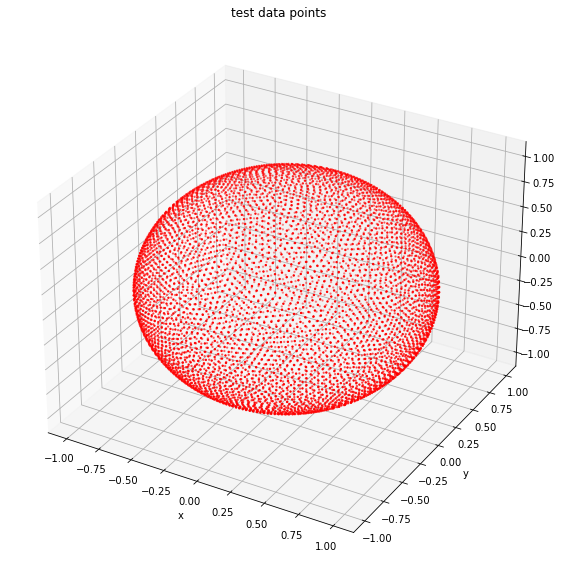

In [5]:
# No. of testing points
N_ts_final = N_tsd_final + N_tsb_final + N_tsg_final
print(f'No. of interior  test data point: N_tsd_final = {N_tsd_final}')
print(f'No. of boundary  test data point: N_tsb_final = {N_tsb_final}')
print(f'No. of interface test data point: N_tsg_final = {N_tsg_final}')
print(f'No. of overall   test data point: N_ts_total  = {N_ts_final}')

# fixed pseudo random generator
np.random.seed(777)

# interior test points
sampling = lhs(n_input0, N_tsd_final)
xd = ba + xw * sampling[:,0:1]
yd = bc + yw * sampling[:,1:2]
zd = be + zw * sampling[:,2:3]
qdo, qd, qdu = levfun(xd, yd, zd)
dqd = qdu[:,1:4]
X_tsd = np.hstack( ( xd , yd , zd , qd ) )
Fd = np.hstack( ( qdu[:,0:1] , 2*qdu[:,1:4] , qdu[:,4:] ) )

# boundary test points
vec_one = np.ones( (N_tsb_final,1) )
sampling = lhs(2, N_tsb_final)
y = bc + yw * sampling[:,0:1]
z = be + zw * sampling[:,1:2]
Xb1 = np.hstack( ( ba * np.ones_like(y) , y , z ) )
Xb2 = np.hstack( ( bb * np.ones_like(y) , y , z ) )
sampling = lhs(2, N_tsb_final)
x = ba + xw * sampling[:,0:1]
z = be + zw * sampling[:,1:2]
Xb3 = np.hstack( ( x , bc * np.ones_like(z) , z ) )
Xb4 = np.hstack( ( x , bd * np.ones_like(z) , z ) )
sampling = lhs(2, N_tsb_final)
x = ba + xw * sampling[:,0:1]
y = bc + yw * sampling[:,1:2]
Xb5 = np.hstack( ( x , y , be * np.ones_like(x) ) )
Xb6 = np.hstack( ( x , y , bf * np.ones_like(x) ) )
# combine
X_tsb = np.vstack( ( Xb1 , Xb2 , Xb3 , Xb4 , Xb5 , Xb6 ) )
qbo, qb, qbu = levfun(X_tsb[:,0:1], X_tsb[:,1:2], X_tsb[:,2:3])
dqb = qbu[:,1:4]
X_tsb = np.hstack( ( X_tsb , qb ) )


# generate interfacial testing points
fname_ts = 'Xg_6644.txt'
X_tsg = np.loadtxt(fname_ts, dtype='float64')
xg = X_tsg[:,0:1]
yg = X_tsg[:,1:2]
zg = X_tsg[:,2:3]
nv1g, nv2g, nv3g, dphi_norm = lvnorvec(xg, yg, zg)
Xg_ts_final = np.hstack( ( xg , yg , zg , np.zeros_like(xg) , np.ones_like(xg) ) )
Fg_ts_final = np.hstack( ( nv1g , nv2g , nv3g , dphi_norm ) ) 

# combine all together
phi_ts_final = np.vstack( ( qdo ) )
Xd_ts_final  = np.vstack( ( X_tsd ) ) #, X_tsb , X_tsg ) )
Fd_ts_final  = np.vstack( ( dqd ) )

# exact solution of u
x = Xd_ts_final[:,0:1]
y = Xd_ts_final[:,1:2]
z = Xd_ts_final[:,2:3]
ref_u_ts, ref_v_ts, ref_w_ts    = exact_uvw(Ex_opt, x, y, z, phi_ts_final)
ref_p_ts                        = exact_p(Ex_opt, x, y, z, phi_ts_final)
ref_px_ts, ref_py_ts, ref_pz_ts = exact_dp(Ex_opt, x, y, z, phi_ts_final)
ref_u_ts_infnorm  = np.linalg.norm(ref_u_ts, np.inf) 
ref_u_ts_L2norm   = np.linalg.norm(ref_u_ts, 2)
ref_v_ts_infnorm  = np.linalg.norm(ref_v_ts, np.inf) 
ref_v_ts_L2norm   = np.linalg.norm(ref_v_ts, 2)
ref_w_ts_infnorm  = np.linalg.norm(ref_w_ts, np.inf) 
ref_w_ts_L2norm   = np.linalg.norm(ref_w_ts, 2)
ref_p_ts_infnorm  = np.linalg.norm(ref_p_ts-ref_p_ts[0], np.inf) 
ref_p_ts_L2norm   = np.linalg.norm(ref_p_ts-ref_p_ts[0], 2)
ref_px_ts_infnorm = np.linalg.norm(ref_px_ts, np.inf) 
ref_px_ts_L2norm  = np.linalg.norm(ref_px_ts, 2)
ref_py_ts_infnorm = np.linalg.norm(ref_py_ts, np.inf) 
ref_py_ts_L2norm  = np.linalg.norm(ref_py_ts, 2)
ref_pz_ts_infnorm = np.linalg.norm(ref_pz_ts, np.inf) 
ref_pz_ts_L2norm  = np.linalg.norm(ref_pz_ts, 2)

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1, 1, 1, projection='3d')
#ax.scatter(X_tsd[:,0:1], X_tsd[:,1:2], X_tsd[:,2:3], s=2, c='b', cmap = "plasma") 
#ax.scatter(X_tsb[:,0:1], X_tsb[:,1:2], X_tsb[:,2:3], s=2, c='g', cmap = "plasma")
ax.scatter(X_tsg[:,0:1], X_tsg[:,1:2], X_tsg[:,2:3], s=2, c='r', cmap = "plasma")
plt.xlabel('x')
plt.ylabel('y')
plt.title('test data points')

plt.show()

# tensor style 
Xd_ts_final = torch.tensor( Xd_ts_final ).double().to(device)
Fd_ts_final = torch.tensor( Fd_ts_final ).double().to(device)
Xg_ts_final = torch.tensor( Xg_ts_final ).double().to(device)
Fg_ts_final = torch.tensor( Fg_ts_final ).double().to(device)

### Define network: Shallow or Deep

In [6]:
class NeuralNet_Shallow(torch.nn.Module):
    
    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output
    
    def __init__(self, in_dim , h_dim_u , h_dim_p, out_dim_u, out_dim_p):
        super(NeuralNet_Shallow, self).__init__()
        # network for u, v, and w
        self.ln1_u  = nn.Linear( in_dim , h_dim_u )
        self.act1_u = nn.Sigmoid()
        self.ln2_u  = nn.Linear( h_dim_u , out_dim_u , bias=False )
        # network for p
        self.ln1_p  = nn.Linear( in_dim , h_dim_p )
        self.act1_p = nn.Sigmoid()
        self.ln2_p  = nn.Linear( h_dim_p , out_dim_p , bias=False )
        
    def forward(self, x):
        # output for u, v, and w
        out_u = torch.hstack( ( x[0] , x[1] , x[2] , x[3] ) )
        out_u = self.ln1_u(out_u)
        out_u = self.act1_u(out_u)
        out_u = self.ln2_u(out_u)
        # output for p
        out_p = torch.hstack( ( x[0] , x[1] , x[2] , x[4] ) )
        out_p = self.ln1_p(out_p)
        out_p = self.act1_p(out_p)
        out_p = self.ln2_p(out_p)
        # output
        out = torch.hstack( ( out_u , out_p ) )
        return out

In [7]:
class NeuralNet_Deep(torch.nn.Module):
    
    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output
    ### depth: depth of the network
    def __init__(self, in_dim , h_dim_u , h_dim_p , out_dim_u , out_dim_p , depth ):
        super(NeuralNet_Deep, self).__init__()
        self.depth = depth - 1
        # u, v, and w
        self.list_u = nn.ModuleList()
        self.ln1_u  = nn.Linear( in_dim , h_dim_u )
        self.act1_u = nn.Sigmoid()
        for i in range(self.depth):
            self.list_u.append( nn.Linear( h_dim_u , h_dim_u ) )
        self.lnd_u = nn.Linear( h_dim_u , out_dim_u , bias=False )
        # p
        self.list_p = nn.ModuleList()
        self.ln1_p  = nn.Linear( in_dim , h_dim_p )
        self.act1_p = nn.Sigmoid()
        for i in range(self.depth):
            self.list_p.append( nn.Linear( h_dim_p , h_dim_p ) )
        self.lnd_p = nn.Linear( h_dim_p , out_dim_p , bias=False )
        
        
    def forward(self, x):
        # u, v, and w
        out_u = torch.hstack( ( x[0] , x[1] , x[2] , x[3] ) )
        out_u = self.ln1_u(out_u)
        out_u = self.act1_u(out_u)
        for i in range(self.depth):
            out_u = self.list_u[i](out_u)
            out_u = self.act1_u(out_u)
        out_u = self.lnd_u(out_u)
        # p
        out_p = torch.hstack( ( x[0] , x[1] , x[2] , x[4] ) )
        out_p = self.ln1_p(out_p)
        out_p = self.act1_p(out_p)
        for i in range(self.depth):
            out_p = self.list_p[i](out_p)
            out_p = self.act1_p(out_p)
        out_p = self.lnd_p(out_p)
        # output
        out = torch.hstack( ( out_u , out_p ) )
        return out

### Essential nametuples in the model

In [8]:
DataInput = namedtuple( "DataInput" , [ "Xd" , "Fd" , "Xb" , "Fb" , "Xg" , "Fg" , "NL" , "NL_sqrt"] )
LM_Setup = namedtuple( "LM_Setup" , [ 'p_vec_o' , 'dp_o' , 'L_o' , 'J_o' , 'mu0' , 'criterion' ] )

### Data generator

In [9]:
def generate_data(iopt, Nd, Nb, Ng):
    
    ## Xd: points inside the domain (randomly)
    sampling = lhs(n_input0, Nd)
    xd = ba + xw * sampling[:,0:1]
    yd = bc + yw * sampling[:,1:2]
    zd = be + zw * sampling[:,2:3]
    qdo, qd, qdu = levfun(xd, yd, zd)
    # remove points at the interface
    qid = np.where(np.abs(qdo)<5e-16)
    qd  = np.delete(qd, qid[0], 0)
    qdu = np.delete(qdu, qid[0], 0)
    xd  = np.delete(xd, qid[0], 0)
    yd  = np.delete(yd, qid[0], 0)
    zd  = np.delete(zd, qid[0], 0)
    qdo = np.delete(qdo, qid[0], 0) 
    Nd_new = len(qdo)
    # augmented input
    Xd = np.hstack( ( xd , yd , zd , qd ) )
    # source 
    g1, g2, g3 = external_g(Ex_opt, xd, yd, zd, qdo)
    # modify right hand side 
    Fd = np.hstack( ( qdu[:,0:1] , 2*qdu[:,1:4] , qdu[:,4:] , 
                      g1/qdu[:,0:1] , g2/qdu[:,0:1] , g3/qdu[:,0:1] , qdu[:,1:4] ) ) 
    
    ## Xb: points respond for boundary condition (randomly)
    vec_one = np.ones( (Nb,1) )
    sampling = lhs(2, Nb)
    y = bc + yw * sampling[:,0:1]
    z = be + zw * sampling[:,1:2]
    Xb1 = np.hstack( ( ba * np.ones_like(y) , y , z ) )
    Xb2 = np.hstack( ( bb * np.ones_like(y) , y , z ) )
    sampling = lhs(2, Nb)
    x = ba + xw * sampling[:,0:1]
    z = be + zw * sampling[:,1:2]
    Xb3 = np.hstack( ( x , bc * np.ones_like(z) , z ) )
    Xb4 = np.hstack( ( x , bd * np.ones_like(z) , z ) )
    sampling = lhs(2, Nb)
    x = ba + xw * sampling[:,0:1]
    y = bc + yw * sampling[:,1:2]
    Xb5 = np.hstack( ( x , y , be * np.ones_like(x) ) )
    Xb6 = np.hstack( ( x , y , bf * np.ones_like(x) ) )
    # combine 
    Xb = np.vstack( ( Xb1 , Xb2 , Xb3 , Xb4 , Xb5 , Xb6 ) )
    # augmented input
    qbo, qb, qbu = levfun(Xb[:,0:1], Xb[:,1:2], Xb[:,2:3])
    Xb = np.hstack( ( Xb , qb ) )
    # Boundary condition
    ub, vb, wb = exact_uvw(Ex_opt, Xb[:,0:1], Xb[:,1:2], Xb[:,2:3], Xb[:,3:4])
    Fb = np.hstack( ( ub , vb , wb ) )
    
    ## X_gma: points on the interface N_trg
    X_trg = np.loadtxt(fname_tr, dtype='float64')
    xg = X_trg[:,0:1]
    yg = X_trg[:,1:2]
    zg = X_trg[:,2:3]
    Ng_new = len(xg)
    Xg = np.hstack( ( xg , yg , zg , np.zeros_like(xg) , np.ones_like(xg) ) )
    # normal vector along the interface
    nv1, nv2, nv3, dphi_norm = lvnorvec(xg, yg, zg)
    # jump and normal derivative jump condition for velocity
    Fxyz_jp = jump_forces(Ex_opt, xg, yg, zg)  
    # combine all sources
    tmp = vis_sum * dphi_norm
    Fg  = np.hstack( ( tmp , nv1 , nv2 , nv3 , vis_jmp*nv1 , vis_jmp*nv2 , vis_jmp*nv3 , 
                       tmp*nv1 , tmp*nv2, tmp*nv3 , Fxyz_jp ) )
        
    # size of each piece of loss
    NB      = 6*Nb
    NL      = [4*Nd_new+3*NB+3*Ng_new, Nd_new, NB, Ng_new]
    NL_sqrt = np.sqrt(NL)
    
        ## plot the distribution of data
    if iopt != 0:
        print(f'No. of training points in the bulk domain: {Nd_new}')
        print(f'No. of training points at the outer boundary: {NB}')
        print(f'No. of training points at the interface: {Ng_new}')
        # set up a figure twice as wide as it is tall
#         fig = plt.figure(figsize=(10,10))
#         ax = fig.add_subplot(1, 1, 1, projection='3d')
#         ax.scatter(Xd[:,0:1], Xd[:,1:2], Xd[:,2:3], s=2, c='b', cmap = "plasma") 
#         ax.scatter(Xb[:,0:1], Xb[:,1:2], Xb[:,2:3], s=2, c='g', cmap = "plasma")
#         ax.scatter(Xg[:,0:1], Xg[:,1:2], Xg[:,2:3], s=2, c='r', cmap = "plasma")
#         plt.xlabel('x')
#         plt.ylabel('y')
#         plt.title('training data points')
#         plt.show()
        
    # torch tensor
    Xd = torch.tensor(Xd, requires_grad=True).double().to(device)
    Fd = torch.tensor(Fd).double().to(device)
    Xb = torch.tensor(Xb, requires_grad=True).double().to(device)
    Fb = torch.tensor(Fb).double().to(device)
    Xg = torch.tensor(Xg, requires_grad=True).double().to(device)
    Fg = torch.tensor(Fg).double().to(device)
 
    return Xd, Fd, Xb, Fb, Xg, Fg, NL, NL_sqrt 

### Components of loss

In [10]:
# compute the interior loss
def func_lsd(func_params, pts, fd):
    def f(x, func_params):
        fx = func_model_uvw_p(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # derivatives of u, v, p wrt inputs
    df   = jacrev(f)(pts, func_params)
    d2f  = jacrev(jacrev(f))(pts, func_params)
    # grad velocity
    u_x  = df[0][0]
    u_q  = df[0][3]
    v_y  = df[1][1]
    v_q  = df[1][3]
    w_z  = df[2][2]
    w_q  = df[2][3]
    p_x  = df[3][0]
    p_y  = df[3][1]
    p_z  = df[3][2]
    # laplacian u
    u_xx = d2f[0][0][0]
    u_yy = d2f[0][1][1]
    u_zz = d2f[0][2][2]
    u_qq = d2f[0][3][3]
    u_xq = d2f[0][0][3]    
    u_yq = d2f[0][1][3]
    u_zq = d2f[0][2][3]
    # laplacian v
    v_xx = d2f[1][0][0]
    v_yy = d2f[1][1][1]
    v_zz = d2f[1][2][2]
    v_qq = d2f[1][3][3]
    v_xq = d2f[1][0][3]
    v_yq = d2f[1][1][3]
    v_zq = d2f[1][2][3]
    # laplacian w
    w_xx = d2f[2][0][0]
    w_yy = d2f[2][1][1]
    w_zz = d2f[2][2][2]
    w_qq = d2f[2][3][3]
    w_xq = d2f[2][0][3]
    w_yq = d2f[2][1][3]
    w_zq = d2f[2][2][3]
    # loss
    lsdu = u_xx + u_yy + u_zz + fd[1]*u_xq + fd[2]*u_yq + fd[3]*u_zq + fd[4]*u_q + fd[5]*u_qq + fd[6] - p_x/fd[0]
    lsdv = v_xx + v_yy + v_zz + fd[1]*v_xq + fd[2]*v_yq + fd[3]*v_zq + fd[4]*v_q + fd[5]*v_qq + fd[7] - p_y/fd[0]
    lsdw = w_xx + w_yy + w_zz + fd[1]*w_xq + fd[2]*w_yq + fd[3]*w_zq + fd[4]*w_q + fd[5]*w_qq + fd[8] - p_z/fd[0]
    lsdp = u_x + v_y + w_z + fd[9]*u_q + fd[10]*v_q + fd[11]*w_q
    return lsdu/udmsesqrt, lsdv/vdmsesqrt, lsdw/wdmsesqrt, lsdp


# compute the boundary loss 
def func_lsb(func_params, pts, fb):
    def f(x, func_params):
        fx = func_model_uvw_p(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # function value at the boundary (Dirichlet boundary condition)
    fval = f(pts, func_params)
    lsbu = fval[0] - fb[0]
    lsbv = fval[1] - fb[1]
    lsbw = fval[2] - fb[2]
    return lsbu/ubmsesqrt, lsbv/vbmsesqrt, lsbw/wbmsesqrt


# compute the interfacial loss
def func_lsg(func_params, pts, fg):
    def f(x, func_params):
        fx = func_model_uvw_p(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # derivatives of u and v
    df = jacrev(f)(pts, func_params)
    u_x = df[0][0]
    u_y = df[0][1]
    u_z = df[0][2]
    u_q = df[0][3]
    v_x = df[1][0]
    v_y = df[1][1]
    v_z = df[1][2]
    v_q = df[1][3]
    w_x = df[2][0]
    w_y = df[2][1]
    w_z = df[2][2]
    w_q = df[2][3]
    # jump of p
    ptsn = torch.hstack( ( pts[0] , pts[1] , pts[2] , pts[3] , -pts[4] ) )
    pp = f(pts, func_params)[3]
    pn = f(ptsn, func_params)[3]
    p_jp = pp - pn
    # jump of u, v, and w
    tp0  = fg[1]*u_q + fg[2]*v_q + fg[3]*w_q 
    tp12 = u_y + v_x
    tp13 = u_z + w_x
    tp23 = v_z + w_y
    lsgu = fg[10] - p_jp*fg[1] + 2*u_x*fg[4] +  tp12*fg[5] +  tp13*fg[6] + u_q*fg[0] + tp0*fg[7] 
    lsgv = fg[11] - p_jp*fg[2] +  tp12*fg[4] + 2*v_y*fg[5] +  tp23*fg[6] + v_q*fg[0] + tp0*fg[8]  
    lsgw = fg[12] - p_jp*fg[3] +  tp13*fg[4] +  tp23*fg[5] + 2*w_z*fg[6] + w_q*fg[0] + tp0*fg[9]  
    return lsgu/ugmsesqrt, lsgv/vgmsesqrt, lsgw/wgmsesqrt

In [11]:
def func_pred_uvwp(func_params, pts, fd):
    def f(x, func_params):
        fx = func_model_uvw_p(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # prediction
    fval = f(pts, func_params)
    u_pred = fval[0]
    v_pred = fval[1]
    w_pred = fval[2]
    p_pred = fval[3]
    # derivatives of f wrt inputs
    df = jacrev(f)(pts, func_params)
    ux_pred  = df[0][0]
    vy_pred  = df[1][1]
    wz_pred  = df[2][2]
    uq_pred  = df[0][3]
    vq_pred  = df[1][3]
    wq_pred  = df[2][3]
    div_pred = ux_pred + vy_pred + wz_pred + fd[0]*uq_pred + fd[1]*vq_pred + fd[2]*wq_pred
    return u_pred, v_pred, w_pred, p_pred, div_pred # px_pred, py_pred 


def func_pred_duvwn(func_params, pts, fg):
    def f(x, func_params):
        fx = func_model_uvw_p(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # interfacial part
    df = jacrev(f)(pts, func_params)
    ux_pred = df[0][0]
    uy_pred = df[0][1]
    uz_pred = df[0][2]
    uq_pred = df[0][3]
    vx_pred = df[1][0]
    vy_pred = df[1][1]
    vz_pred = df[1][2]
    vq_pred = df[1][3]
    wx_pred = df[2][0]
    wy_pred = df[2][1]
    wz_pred = df[2][2]
    wq_pred = df[2][3]
    tpu  = ux_pred*fg[0] + uy_pred*fg[1] + uz_pred*fg[2]
    tpuq = uq_pred*fg[3]
    tpv  = vx_pred*fg[0] + vy_pred*fg[1] + vz_pred*fg[2]
    tpvq = vq_pred*fg[3]
    tpw  = wx_pred*fg[0] + wy_pred*fg[1] + wz_pred*fg[2]
    tpwq = wq_pred*fg[3]
    dupn_pred = tpu + tpuq
    dunn_pred = tpu - tpuq
    dvpn_pred = tpv + tpvq
    dvnn_pred = tpv - tpvq
    dwpn_pred = tpw + tpwq
    dwnn_pred = tpw - tpwq
    return dupn_pred, dunn_pred, dvpn_pred, dvnn_pred, dwpn_pred, dwnn_pred

### Levenberg-Marquardt (LM) optimizer

In [12]:
# parameters counter
def count_parameters(func_params):
    return sum(p.numel() for p in func_params if p.requires_grad)

In [13]:
# get the model's parameter
def get_p_vec(func_params):
    p_vec = []
    cnt = 0
    for p in func_params:
        p_vec = p.contiguous().view(-1) if cnt == 0 else torch.cat([p_vec, p.contiguous().view(-1)])
        cnt = 1 
    return p_vec

In [14]:
# Initialization of LM method
def generate_initial_LM(func_params, data_length):
    
    # p_vector
    with torch.no_grad():
        p_vec_old = get_p_vec(func_params).double().to(device)
    
    # dp
    dp_old = torch.zeros( [ count_parameters(func_params) , 1 ] ).double().to(device)

    # Loss
    L_old = torch.zeros( [ data_length , 1 ] ).double().to(device)
    
    # Jacobian
    J_old = torch.zeros( [ data_length , count_parameters(func_params) ] ).double().to(device)
    
    return p_vec_old, dp_old, L_old, J_old

In [15]:
def train_PINNs_uvw_p_LM(func_params, LM_setup, tr_input, ts_input, lossval, lossval_ts):
    
    # assign tuple elements of LM_set_up
    p_vec_o, dp_o, L_o, J_o, mu, criterion = LM_setup
    I_pvec = torch.eye(len(p_vec_o)).to(device)
    
    # assign tuple elements of data_input 
    [Xd, Fd, Xb, Fb, Xg, Fg, NL, NL_sqrt] = tr_input
    [Xd_ts, Fd_ts, Xb_ts, Fb_ts, Xg_ts, Fg_ts, NL_ts, NL_sqrt_ts] = ts_input
    
    ### computation of loss
    Ldu, Ldv, Ldw, Ldp = vmap((func_lsd), (None, 0, 0))(func_params, Xd, Fd)
    Lbu, Lbv, Lbw      = vmap((func_lsb), (None, 0, 0))(func_params, Xb, Fb)
    Lgu, Lgv, Lgw      = vmap((func_lsg), (None, 0, 0))(func_params, Xg, Fg)
    L = torch.cat( ( torch.cat( ( Ldu , Ldv , Ldw , Ldp ) )/NL_sqrt[1] , \
                     torch.cat( ( Lbu , Lbv , Lbw ) )/NL_sqrt[2] , \
                     torch.cat( ( Lgu , Lgv , Lgw ) )/NL_sqrt[3] ) )
    L = L.reshape(NL[0],1).detach()
    lsd_sum = torch.sum( Ldu**2 + Ldv**2 + Ldw**2 + Ldp**2 ) / NL[1]
    lsb_sum = torch.sum( Lbu**2 + Lbv**2 + Lbw**2 ) / NL[2] 
    lsg_sum = torch.sum( Lgu**2 + Lgv**2 + Lgw**2 ) / NL[3]
    ls_sum  = lsd_sum + lsb_sum + lsg_sum
    lossval[0,:] = [0, lsd_sum.item(), lsb_sum.item(), lsg_sum.item(), ls_sum.item()]
    
    # iteration counts and check
    func_params_best = deepcopy(func_params)
    loss_best  = np.ones((2,1)).reshape((2))
    ts_over_tr = ts_over_tr_tol
    step       = 0
    step_ts    = 0
    loss_now   = ls_sum.item()
    
    # try-except statement to avoid jam in the code
    try:
        while (loss_now>tol_main1 or ts_over_tr>=100.) and (step<=tr_iter_max):
            
            torch.cuda.empty_cache()
            
            ### compute the gradinet of loss function for each point
            with torch.no_grad():
                p_vec = get_p_vec(func_params).detach() # get p_vec for p_vec_old if neccessary 
        
            if criterion:
                gdu, gdv, gdw, gdp = vmap(jacrev(func_lsd), (None, 0, 0))(func_params, Xd, Fd)
                cnt = 0
                for g in gdu: 
                    g = g.detach()
                    Ju_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Ju_d,g.reshape(len(g),-1)])
                    cnt = 1
                cnt = 0
                for g in gdv: 
                    g = g.detach()
                    Jv_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Jv_d,g.reshape(len(g),-1)])
                    cnt = 1
                cnt = 0
                for g in gdw: 
                    g = g.detach()
                    Jw_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Jw_d,g.reshape(len(g),-1)])
                    cnt = 1
                cnt = 0
                for g in gdp: 
                    g = g.detach()
                    Jp_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Jp_d,g.reshape(len(g),-1)])
                    cnt = 1

                gdu, gdv, gdw = vmap(jacrev(func_lsb), (None, 0, 0))(func_params, Xb, Fb)
                cnt = 0
                for g in gdu: 
                    g = g.detach()
                    Ju_b = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Ju_b,g.reshape(len(g),-1)])
                    cnt = 1
                cnt = 0
                for g in gdv: 
                    g = g.detach()
                    Jv_b = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Jv_b,g.reshape(len(g),-1)])
                    cnt = 1
                cnt = 0
                for g in gdw: 
                    g = g.detach()
                    Jw_b = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Jw_b,g.reshape(len(g),-1)])
                    cnt = 1
                    
                gdu, gdv, gdw = vmap(jacrev(func_lsg), (None, 0, 0))(func_params, Xg, Fg)
                cnt = 0
                for g in gdu: 
                    g = g.detach()
                    Ju_g = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Ju_g,g.reshape(len(g),-1)])
                    cnt = 1
                cnt = 0
                for g in gdv: 
                    g = g.detach()
                    Jv_g = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Jv_g,g.reshape(len(g),-1)])
                    cnt = 1
                cnt = 0
                for g in gdw: 
                    g = g.detach()
                    Jw_g = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([Jw_g,g.reshape(len(g),-1)])
                    cnt = 1
                
                J = torch.cat( ( torch.cat( ( Ju_d , Jv_d , Jw_d , Jp_d ) )/NL_sqrt[1] , \
                                 torch.cat( ( Ju_b , Jv_b , Jw_b ) )/NL_sqrt[2] , \
                                 torch.cat( ( Ju_g , Jv_g , Jw_g ) )/NL_sqrt[3] ) ).detach()
                
                ### info. normal equation of J
                J_product = J.t()@J
                rhs       = - J.t()@L
                 
                    
            with torch.no_grad():
                ### solve the linear system
                dp  = torch.linalg.solve( J_product + mu*I_pvec , rhs )
                cnt = 0
                for p in func_params:
                    mm   = torch.Tensor([p.shape]).tolist()[0]
                    num  = int( functools.reduce( lambda x,y : x*y, mm, 1 ) )
                    p   += dp[cnt:cnt+num].reshape(p.shape)
                    cnt += num
            
            ### Compute loss_new    
            Ldu, Ldv, Ldw, Ldp = vmap((func_lsd), (None, 0, 0))(func_params, Xd, Fd)
            Lbu, Lbv, Lbw      = vmap((func_lsb), (None, 0, 0))(func_params, Xb, Fb)
            Lgu, Lgv, Lgw      = vmap((func_lsg), (None, 0, 0))(func_params, Xg, Fg)
            L = torch.cat( ( torch.cat( ( Ldu , Ldv , Ldw , Ldp ) )/NL_sqrt[1] , \
                             torch.cat( ( Lbu , Lbv , Lbw ) )/NL_sqrt[2] , \
                             torch.cat( ( Lgu , Lgv , Lgw ) )/NL_sqrt[3] ) )
            L = L.reshape(NL[0],1).detach()
            loss_new = torch.sum(L*L).item()
            lsd_sum = torch.sum( Ldu**2 + Ldv**2 + Ldw**2 + Ldp**2 )/NL[1]
            lsb_sum = torch.sum( Lbu**2 + Lbv**2 + Lbw**2 )/NL[2]
            lsg_sum = torch.sum( Lgu**2 + Lgv**2 + Lgw**2 )/NL[3]
                   
            # strategy to update mu
            if ( step > 0 ):
                
                with torch.no_grad():
             
                    # accept update 
                    if loss_new < loss_now:
                        p_vec_old  = p_vec.detach()
                        dp_old     = dp
                        L_old      = L
                        J_old      = J
                        mu         = max( mu/mu_div , tol_machine )
                        criterion  = True #False
                        lossval[step,:] = [step, lsd_sum.item(), lsb_sum.item(), lsg_sum.item(), loss_new]
                        loss_now = loss_new
                    
                    else:
                        cosine = nn.functional.cosine_similarity(dp, dp_old, dim=0, eps=1e-15)
                        cosine_check = (1.-cosine)*loss_new > min(lossval[0:step-1,-1]) 
                        if cosine_check: # give up the direction
                            cnt=0
                            for p in func_params:
                                mm   = torch.Tensor([p.shape]).tolist()[0]
                                num  = int( functools.reduce(lambda x,y: x*y, mm, 1) )
                                p   -= dp[cnt:cnt+num].reshape(p.shape)
                                cnt += num
                            mu = min( mu_mul*mu , mu_max )
                            criterion  = False
                        else: # accept 
                            p_vec_old = p_vec.detach()
                            dp_old    = dp 
                            L_old     = L
                            J_old     = J
                            mu        = max( mu/mu_div , tol_machine )       
                            criterion  = True
                        lossval[step,0] = step
                        lossval[step,1:] = lossval[step-1,1:]
            
            else:   # for old info. 
       
                with torch.no_grad():
              
                    p_vec_old  = p_vec.detach()
                    dp_old     = dp
                    L_old      = L
                    J_old      = J
                    mu         = max( mu/mu_div , tol_machine )
                    criterion  = True
                    lossval[step,:] = [step, lsd_sum.item(), lsb_sum.item(), lsg_sum.item(), loss_new]
                    loss_now = loss_new

            
            # generate new testing data point
            if step % ts_input_new == 0:
                Xd_ts, Fd_ts, Xb_ts, Fb_ts, Xg_ts, Fg_ts, NL_ts, NL_sqrt_ts = generate_data(0, N_tsd, N_tsb, N_tsg)
                ts_input = DataInput(Xd=Xd_ts, Fd=Fd_ts, Xb=Xb_ts, Fb=Fb_ts, Xg=Xg_ts, Fg=Fg_ts, NL=NL_ts, NL_sqrt=NL_sqrt_ts)
                Xd_ts, Fd_ts, Xb_ts, Fb_ts, Xg_ts, Fg_ts, NL_ts, NL_sqrt_ts = ts_input
                print(f'Pass renew testing points at step {step}!')
            
                # compute testing loss
                Ldu_ts, Ldv_ts, Ldw_ts, Ldp_ts = vmap((func_lsd), (None, 0, 0))(func_params, Xd_ts, Fd_ts)
                Lbu_ts, Lbv_ts, Lbw_ts         = vmap((func_lsb), (None, 0, 0))(func_params, Xb_ts, Fb_ts)
                Lgu_ts, Lgv_ts, Lgw_ts         = vmap((func_lsg), (None, 0, 0))(func_params, Xg_ts, Fg_ts)
                Lts = torch.cat( ( torch.cat( ( Ldu_ts , Ldv_ts , Ldw_ts , Ldp_ts ) )/NL_sqrt_ts[1] , \
                                   torch.cat( ( Lbu_ts , Lbv_ts , Lbw_ts ) )/NL_sqrt_ts[2] , \
                                   torch.cat( ( Lgu_ts , Lgv_ts , Lgw_ts ) )/NL_sqrt_ts[3] ) )
                Lts     = Lts.reshape(NL_ts[0], 1).detach()
                Lts_sum = torch.sum(Lts**2).item()
                lsd_sum = torch.sum( Ldu_ts**2 + Ldv_ts**2 + Ldw_ts**2 + Ldp_ts**2 )/NL_ts[1]
                lsb_sum = torch.sum( Lbu_ts**2 + Lbv_ts**2 + Lbw_ts**2 )/NL_ts[2]
                lsg_sum = torch.sum( Lgu_ts**2 + Lgv_ts**2 + Lgw_ts**2 )/NL_ts[3]
                lossval_ts[step_ts,:] = [step, lsd_sum.item(), lsb_sum.item(), lsg_sum.item(), Lts_sum]
                step_ts += 1
                
                ts_over_tr = Lts_sum/loss_now

                print("Step %s: " % (step) )
                print(f" training loss: {loss_now:.4e}")
                print(f" testing loss : {Lts_sum:.4e}")
                print(f" L_ts/L_tr: {ts_over_tr:.4e}")
                print(f" mu: {mu}")
                
                if ( ts_over_tr < 10. ):
                    loss_best[0] = loss_now
                    loss_best[1] = Lts_sum
                    func_params_best = deepcopy(func_params)
                   
            step += 1
        
        lossval[-1,-1] = loss_now
        lossval_ts[-1,-1] = Lts_sum
        print("Step %s: " % (step-1) )
        print(f" training loss: {lossval[-1,-1]:.4e}")
        print(f" testing loss : {lossval_ts[-1,-1]:.4e}")
        print(f" L_ts/L_tr: {ts_over_tr:.4e}")
        print(f" mu: {mu}")
        print('finished')
        return lossval, lossval_ts, func_params_best, loss_best
    
    except KeyboardInterrupt:
        print('interpret')
        print(step)
        return lossval, lossval_ts, func_params_best, loss_best

### Main procedures

In [16]:
# create names for storages
fname = 'ex3D_Ex2_eta10_Xg816Xb2400Xd3000_Sp30u75Mxxxx'
char_id = ['a','b','c'] #,'e','f','g','h','i','j']
fname_tr = 'Xg_816.txt'
#fname_tr = 'Xg_1114.txt'

# tolerence for LM
tol_main1   = 1e-14
tol_main2   = 1e-15
tol_machine = 1e-15
mu_max      = 10**8
mu_ini      = 10**8
mu_mul      = 2.
mu_div      = 1.2
# iteration counts and check
tr_iter_max    = 20000                      # max. iteration
ts_input_new   = 1000                       # renew testing points 
ts_over_tr_tol = 100.
# Network size
n_h_u   = 75
n_h_p   = 30
n_o_u   = 3
n_o_p   = 1
n_depth = 1 # only used in deep NN
# number of training points and testing points
c_addpt = 1.
N_trd = 3000
N_trb = 400
N_trg = 1000
N_tsd = int(c_addpt*N_trd)
N_tsb = int(c_addpt*N_trb)
N_tsg = int(c_addpt*N_trg)

# relative errors and losses
relerr_loss = []

for char in char_id:
    
    # file name
    fname_char = fname+char 

    torch.cuda.empty_cache()
    
    # NN structure
    if n_depth == 1:   # Shallow NN
        model_uvw_p = NeuralNet_Shallow(n_input, n_h_u, n_h_p, n_o_u, n_o_p).double().to(device)
        N_totpar = n_h_u * ( n_input + n_o_u + 1 ) + n_h_p * ( n_input + n_o_p + 1 )
    else:   # Deep NN
        model_uvw_p = NeuralNet_Deep(n_input, n_h_u, n_h_p, n_o_u, n_o_p, n_depth).double().to(device)
        N_totpar = n_h_u * ( (n_input+n_o_u+1) + (n_depth-1)*n_h_u ) + \
                   n_h_p * ( (n_input+n_o_p+1) + (n_depth-1)*n_h_p )
    print(f"U & V: No. of input {n_input}, hidden layer {n_depth} ({n_h_u} neurons each layer) and output {n_o_u}")
    print(f"P: No. of input {n_input}, hidden layer {n_depth} ({n_h_p} neurons each layer) and output {n_o_p}")
    print(f'No. of total trainable parameters:{N_totpar}')    
    
    # use Pytorch and functorch
    func_model_uvw_p, func_params_uvw_p = make_functional(model_uvw_p)
    print(model_uvw_p)
    
    # generate training data
    Xd_tr, Fd_tr, Xb_tr, Fb_tr, Xg_tr, Fg_tr, NL_tr, NL_sqrt_tr = generate_data(1, N_trd, N_trb, N_trg)
    tr_input = DataInput(Xd=Xd_tr, Fd=Fd_tr, Xb=Xb_tr, Fb=Fb_tr, Xg=Xg_tr, Fg=Fg_tr, NL=NL_tr, NL_sqrt=NL_sqrt_tr)
    udmsesqrt = torch.sqrt( torch.sum(Fd_tr[:,6:7]**2)/N_trd )
    vdmsesqrt = torch.sqrt( torch.sum(Fd_tr[:,7:8]**2)/N_trd )
    wdmsesqrt = torch.sqrt( torch.sum(Fd_tr[:,8:9]**2)/N_trd )
    ubmsesqrt = 1. #torch.sqrt( torch.sum(Fb_tr[:,0:1]**2)/N_trb )
    vbmsesqrt = 1. #torch.sqrt( torch.sum(Fb_tr[:,1:2]**2)/N_trb )
    wbmsesqrt = 1. #torch.sqrt( torch.sum(Fb_tr[:,2:3]**2)/N_trb )
    ugmsesqrt = 1. #torch.sqrt( torch.sum(Fg_tr[:,10:11]**2)/N_trg )
    vgmsesqrt = 1. #torch.sqrt( torch.sum(Fg_tr[:,11:12]**2)/N_trg )
    wgmsesqrt = 1. #torch.sqrt( torch.sum(Fg_tr[:,12:13]**2)/N_trg )
    
    # generate testing data
    Xd_ts, Fd_ts, Xb_ts, Fb_ts, Xg_ts, Fg_ts, NL_ts, NL_sqrt_ts = generate_data(0, N_tsd, N_tsb, N_tsg)
    ts_input = DataInput(Xd=Xd_ts, Fd=Fd_ts, Xb=Xb_ts, Fb=Fb_ts, Xg=Xg_ts, Fg=Fg_ts, NL=NL_ts, NL_sqrt=NL_sqrt_ts)
        
    # initialization of LM
    p_vec_old, dp_old, L_old, J_old = generate_initial_LM(func_params_uvw_p, NL_tr[0])
        
    # LM_setup
    mu = 10**(8)
    criterion = True
    LM_setup = LM_Setup( p_vec_o=p_vec_old , dp_o=dp_old , L_o=L_old , J_o=J_old , mu0=mu , criterion=criterion )

    # allocate loss
    lossval    = np.zeros((tr_iter_max+1,5))
    lossval_ts = np.zeros(((int(tr_iter_max/ts_input_new)+1),5))

    # start the timer
    cnt_start = time.time()

    # train the model by LM optimizer
    lossval, lossval_ts, func_params_uvw_p_best, loss_best = train_PINNs_uvw_p_LM(func_params_uvw_p, 
                                                             LM_setup, tr_input, ts_input, lossval, lossval_ts)
    
    end_start = time.time()
    total_T = str(datetime.timedelta(seconds=end_start-cnt_start))
    print(f"total time : {total_T}")
    
    print(f"Training loss and test loss:")
    print(f"Loss_tr = {lossval[-1,-1]:.2e}")
    print(f"Loss_ts = {lossval_ts[-1,-1]:.2e}")
    
    np.savetxt('fig_'+fname_char+'_loss_tr.txt',lossval)

    
    ########## relative errors and losses
    u, v, w, p, div = vmap((func_pred_uvwp),(None,0,0))(func_params_uvw_p,  Xd_ts_final, Fd_ts_final)
    dupn, dunn, dvpn, dvnn, dwpn, dwnn = vmap((func_pred_duvwn),(None,0,0))(func_params_uvw_p, Xg_ts_final, Fg_ts_final)
    
    u = u.detach().numpy()
    v = v.detach().numpy()
    w = w.detach().numpy()
    p = p.detach().numpy()
#     dupn = dupn.detach().numpy()
#     dunn = dunn.detach().numpy()
#     dvpn = dvpn.detach().numpy()
#     dvnn = dvnn.detach().numpy()
#     dwpn = dwpn.detach().numpy()
#     dwnn = dwnn.detach().numpy()
    
    abserru    = np.abs( u - ref_u_ts.flatten() )
    abserrv    = np.abs( v - ref_v_ts.flatten() )
    abserrw    = np.abs( w - ref_w_ts.flatten() )
    abserrp    = np.abs( p - ref_p_ts.flatten() - (p[0]-ref_p_ts[0]) )
#     abserrdupn = np.abs( dupn - ref_dupn_ts.flatten() )
#     abserrdunn = np.abs( dunn - ref_dunn_ts.flatten() )
#     abserrdvpn = np.abs( dvpn - ref_dvpn_ts.flatten() )
#     abserrdvnn = np.abs( dvnn - ref_dvnn_ts.flatten() )
#     abserrdwpn = np.abs( dwpn - ref_dwpn_ts.flatten() )
#     abserrdwnn = np.abs( dwnn - ref_dwnn_ts.flatten() )
    
    abserrdiv  = np.linalg.norm(div.detach().numpy(), np.inf)

    print(f"")
    print(f"Divengence:")
    print(f"L_inf norm of u_x+v_y+w_z: {abserrdiv: .2e}")
    
    print(f"")
    print(f"Error p: ")
    abserrp_inf = np.linalg.norm(abserrp, np.inf)
    abserrp_L2  = np.linalg.norm(abserrp, 2)
    relerrp_inf = abserrp_inf / ref_p_ts_infnorm
    relerrp_L2  = abserrp_L2  / ref_p_ts_L2norm
    print(f" Max. err. = {abserrp_inf:.2e}; L_inf relerr. = {relerrp_inf:.2e}; L_2 relerr. = {relerrp_L2:.2e}")    
    
    print(f"")
    print(f"Error u: ")
    abserru_inf = np.linalg.norm(abserru, np.inf)
    abserru_L2  = np.linalg.norm(abserru, 2)
    relerru_inf = abserru_inf / ref_u_ts_infnorm
    relerru_L2  = abserru_L2  / ref_u_ts_L2norm
    print(f" Max. err. = {abserru_inf:.2e}; L_inf relerr. = {relerru_inf:.2e}; L_2 relerr. = {relerru_L2:.2e}")
    
    print(f"")
    print(f"Error v: ")
    abserrv_inf = np.linalg.norm(abserrv, np.inf)
    abserrv_L2  = np.linalg.norm(abserrv, 2)
    relerrv_inf = abserrv_inf / ref_v_ts_infnorm
    relerrv_L2  = abserrv_L2  / ref_v_ts_L2norm
    print(f" Max. err. = {abserrv_inf:.2e}; L_inf relerr. = {relerrv_inf:.2e}; L_2 relerr. = {relerrv_L2:.2e}")
    
    print(f"")
    print(f"Error w: ")
    abserrw_inf = np.linalg.norm(abserrw, np.inf)
    abserrw_L2  = np.linalg.norm(abserrw, 2)
    relerrw_inf = abserrw_inf / ref_w_ts_infnorm
    relerrw_L2  = abserrw_L2  / ref_w_ts_L2norm
    print(f" Max. err. = {abserrw_inf:.2e}; L_inf relerr. = {relerrw_inf:.2e}; L_2 relerr. = {relerrw_L2:.2e}")

#     print(f"")
#     print(f"Error of derivatives along normal:")
#     abserrdupnmx = np.linalg.norm(abserrdupn, np.inf)
#     abserrdunnmx = np.linalg.norm(abserrdunn, np.inf) 
#     abserrdvpnmx = np.linalg.norm(abserrdvpn, np.inf) 
#     abserrdvnnmx = np.linalg.norm(abserrdvnn, np.inf)
#     relerrdupn_inf = abserrdupnmx / ( ref_dupn_ts_infnorm + 1e-8 )
#     relerrdunn_inf = abserrdunnmx / ( ref_dunn_ts_infnorm + 1e-8 )
#     relerrdvpn_inf = abserrdvpnmx / ( ref_dvpn_ts_infnorm + 1e-8 )
#     relerrdvnn_inf = abserrdvnnmx / ( ref_dvnn_ts_infnorm + 1e-8 )
#     print(f"Max.  abserr. dupn = {abserrdupnmx:.2e}; max. dupn = {ref_dupn_ts_infnorm:.2e}")
#     print(f"Max.  abserr. dunn = {abserrdunnmx:.2e}; max. dunn = {ref_dunn_ts_infnorm:.2e}")
#     print(f"Max.  abserr. dvpn = {abserrdvpnmx:.2e}; max. dvpn = {ref_dvpn_ts_infnorm:.2e}")
#     print(f"Max.  abserr. dvnn = {abserrdvnnmx:.2e}; max. dvnn = {ref_dvnn_ts_infnorm:.2e}")
#     print(f"")
    print(f"")
    print(f"")
    relerr_loss_k = [abserrp_inf, relerrp_inf, relerrp_L2, \
                     abserru_inf, relerru_inf, relerru_L2, \
                     abserrv_inf, relerrv_inf, relerrv_L2, \
                     abserrw_inf, relerrw_inf, relerrw_L2, \
#                      abserrdupnmx, relerrdupn_inf, abserrdunnmx, relerrdunn_inf, \
#                      abserrdvpnmx, relerrdvpn_inf, abserrdvnnmx, relerrdvnn_inf, \
                     abserrdiv, lossval[-1,-1], lossval_ts[-1,-1]]
    
    relerr_loss.append(relerr_loss_k)

np.savetxt('tab_'+fname+'_FXYZ_5runs.txt',relerr_loss)

U & V: No. of input 4, hidden layer 1 (75 neurons each layer) and output 3
P: No. of input 4, hidden layer 1 (30 neurons each layer) and output 1
No. of total trainable parameters:780
NeuralNet_Shallow(
  (ln1_u): Linear(in_features=4, out_features=75, bias=True)
  (act1_u): Sigmoid()
  (ln2_u): Linear(in_features=75, out_features=3, bias=False)
  (ln1_p): Linear(in_features=4, out_features=30, bias=True)
  (act1_p): Sigmoid()
  (ln2_p): Linear(in_features=30, out_features=1, bias=False)
)
No. of training points in the bulk domain: 3000
No. of training points at the outer boundary: 2400
No. of training points at the interface: 816
Pass renew testing points at step 0!
Step 0: 
 training loss: 4.2952e+01
 testing loss : 4.2721e+01
 L_ts/L_tr: 9.9462e-01
 mu: 83333333.33333334
Pass renew testing points at step 1000!
Step 1000: 
 training loss: 1.1251e-05
 testing loss : 4.4321e-03
 L_ts/L_tr: 3.9393e+02
 mu: 2.1567204861598368e-10
Pass renew testing points at step 2000!
Step 2000: 
 train

Pass renew testing points at step 20000!
Step 20000: 
 training loss: 7.6851e-09
 testing loss : 1.6250e-08
 L_ts/L_tr: 2.1144e+00
 mu: 100000000
Step 20000: 
 training loss: 7.6851e-09
 testing loss : 1.6250e-08
 L_ts/L_tr: 2.1144e+00
 mu: 100000000
finished
total time : 9:23:51.764725
Training loss and test loss:
Loss_tr = 7.69e-09
Loss_ts = 1.62e-08

Divengence:
L_inf norm of u_x+v_y+w_z:  1.02e-03

Error p: 
 Max. err. = 4.51e-04; L_inf relerr. = 1.05e-02; L_2 relerr. = 1.36e-02

Error u: 
 Max. err. = 1.11e-04; L_inf relerr. = 9.59e-06; L_2 relerr. = 7.41e-06

Error v: 
 Max. err. = 8.25e-05; L_inf relerr. = 7.04e-06; L_2 relerr. = 6.61e-06

Error w: 
 Max. err. = 1.43e-04; L_inf relerr. = 1.84e-05; L_2 relerr. = 1.06e-05


U & V: No. of input 4, hidden layer 1 (75 neurons each layer) and output 3
P: No. of input 4, hidden layer 1 (30 neurons each layer) and output 1
No. of total trainable parameters:780
NeuralNet_Shallow(
  (ln1_u): Linear(in_features=4, out_features=75, bias=Tru

Text(0.5, 1.0, 'loss')

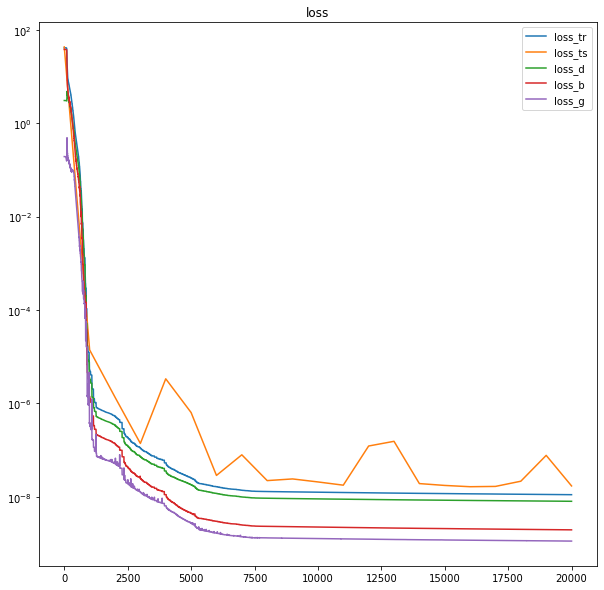

In [17]:
# plot evolution of loss
plt.figure(figsize = (10,10))

plt.semilogy(lossval[:,0:1], lossval[:,4:5])
plt.semilogy(lossval_ts[:,0:1], lossval_ts[:,4:5])
plt.semilogy(lossval[:,0:1], lossval[:,1:2])
plt.semilogy(lossval[:,0:1], lossval[:,2:3])
plt.semilogy(lossval[:,0:1], lossval[:,3:4])
plt.legend(['loss_tr', 'loss_ts' , 'loss_d', 'loss_b', 'loss_g'], loc='upper right')
plt.title('loss')

In [18]:
########## relative errors and losses
u, v, w, p, div = vmap((func_pred_uvwp),(None,0,0))(func_params_uvw_p,  Xd_ts_final, Fd_ts_final)
dupn, dunn, dvpn, dvnn, dwpn, dwnn = vmap((func_pred_duvwn),(None,0,0))(func_params_uvw_p, Xg_ts_final, Fg_ts_final)
    
u = u.detach().numpy()
v = v.detach().numpy()
w = w.detach().numpy()
p = p.detach().numpy()
    
abserru    = np.abs( u - ref_u_ts.flatten() )
abserrv    = np.abs( v - ref_v_ts.flatten() )
abserrw    = np.abs( w - ref_w_ts.flatten() )
abserrp    = np.abs( p - ref_p_ts.flatten() - (p[0]-ref_p_ts[0]) )
    
abserrdiv  = np.linalg.norm(div.detach().numpy(), np.inf)

print(f"")
print(f"Divengence:")
print(f"L_inf norm of u_x+v_y+w_z: {abserrdiv: .2e}")
    
print(f"")
print(f"Error p: ")
abserrp_inf = np.linalg.norm(abserrp, np.inf)
abserrp_L2  = np.linalg.norm(abserrp, 2)
relerrp_inf = abserrp_inf / ref_p_ts_infnorm
relerrp_L2  = abserrp_L2  / ref_p_ts_L2norm
print(f" Max. err. = {abserrp_inf:.2e}; L_inf relerr. = {relerrp_inf:.2e}; L_2 relerr. = {relerrp_L2:.2e}")    
    
print(f"")
print(f"Error u: ")
abserru_inf = np.linalg.norm(abserru, np.inf)
abserru_L2  = np.linalg.norm(abserru, 2)
relerru_inf = abserru_inf / ref_u_ts_infnorm
relerru_L2  = abserru_L2  / ref_u_ts_L2norm
print(f" Max. err. = {abserru_inf:.2e}; L_inf relerr. = {relerru_inf:.2e}; L_2 relerr. = {relerru_L2:.2e}")
    
print(f"")
print(f"Error v: ")
abserrv_inf = np.linalg.norm(abserrv, np.inf)
abserrv_L2  = np.linalg.norm(abserrv, 2)
relerrv_inf = abserrv_inf / ref_v_ts_infnorm
relerrv_L2  = abserrv_L2  / ref_v_ts_L2norm
print(f" Max. err. = {abserrv_inf:.2e}; L_inf relerr. = {relerrv_inf:.2e}; L_2 relerr. = {relerrv_L2:.2e}")
    
print(f"")
print(f"Error w: ")
abserrw_inf = np.linalg.norm(abserrw, np.inf)
abserrw_L2  = np.linalg.norm(abserrw, 2)
relerrw_inf = abserrw_inf / ref_w_ts_infnorm
relerrw_L2  = abserrw_L2  / ref_w_ts_L2norm
print(f" Max. err. = {abserrw_inf:.2e}; L_inf relerr. = {relerrw_inf:.2e}; L_2 relerr. = {relerrw_L2:.2e}")



Divengence:
L_inf norm of u_x+v_y+w_z:  7.38e-04

Error p: 
 Max. err. = 3.26e-04; L_inf relerr. = 7.55e-03; L_2 relerr. = 1.07e-02

Error u: 
 Max. err. = 2.20e-04; L_inf relerr. = 1.90e-05; L_2 relerr. = 9.49e-06

Error v: 
 Max. err. = 1.94e-04; L_inf relerr. = 1.66e-05; L_2 relerr. = 9.13e-06

Error w: 
 Max. err. = 1.17e-04; L_inf relerr. = 1.51e-05; L_2 relerr. = 1.57e-05
